In [1]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np
import pickle
import gym
import matplotlib.pyplot as plt

In [2]:
NUM_RUNS = 10
EPSILON = 0.4      # placeholder value - you should implement your own exploration schedule
EPSILON_DECAY = 0.98
FREQ_UPDATE_TARGET = 10 #(?)
BUFFER_LEN = 200000
BATCH_SIZE = 40
LEARNING_RATE = 0.005
LAYER_LIST = [4,17,2]
NEURON = LAYER_LIST[1]
is_DDQN = True # whether to convert into DDQN

In [3]:
runs_results = []

env = gym.make('CartPole-v1')
for run in range(NUM_RUNS):
    print(f"Starting run {run+1} of {NUM_RUNS}")
    policy_net = DQN(LAYER_LIST) #fast Q
    target_net = DQN(LAYER_LIST) #slow Q
    update_target(target_net, policy_net) #make two network have the same initialisation
    target_net.eval() #set target Q into eval mode: i.e. not training

    optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE) #Adaptive gradient descent
    memory = ReplayBuffer(BUFFER_LEN) # create a queue with maximum len 1 # hyperparam BUFFER_MAXLEN?

    steps_done = 0
    
    episode_durations = []

    for i_episode in range(300): # hyperparam: nb_episode
        epsilon =  EPSILON* (EPSILON_DECAY)**i_episode
        if (i_episode+1) % 100 == 0:
            print("episode ", i_episode+1, "/", 300)
        observation, info = env.reset() # obs=state, info= empty dict()
        state = torch.tensor(observation).float() #convert state to tensor

        done = False # failure of condition
        terminated = False # success in this episode
        t = 0
        while not (done or terminated):

            # Select and perform an action
            action = epsilon_greedy(epsilon, policy_net, state)
                
            observation, reward, done, terminated, info = env.step(action)
            reward = torch.tensor([reward])
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()

            memory.push([state, action, next_state, reward, torch.tensor([done])]) #add transition into queue

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < BATCH_SIZE:# change 1 to batch_size?
                transitions = memory.sample(BATCH_SIZE) # maybe need to filter trans first then sample
                # stack all states, actions,... in a batch. "*" means individual element
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones, is_DDQN)
                
                # Optimize the model
                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()
            
            if done or terminated:
                episode_durations.append(t + 1)
            t += 1
        # Update the target network, copying all weights and biases in DQN
        if i_episode % FREQ_UPDATE_TARGET == 0: # TODO: need to change freq of update target here
            update_target(target_net, policy_net)
    runs_results.append(episode_durations)
print('Complete')

Starting run 1 of 10
episode  100 / 300
episode  200 / 300
episode  300 / 300
Starting run 2 of 10
episode  100 / 300
episode  200 / 300
episode  300 / 300
Starting run 3 of 10
episode  100 / 300
episode  200 / 300
episode  300 / 300
Starting run 4 of 10
episode  100 / 300
episode  200 / 300
episode  300 / 300
Starting run 5 of 10
episode  100 / 300
episode  200 / 300
episode  300 / 300
Starting run 6 of 10
episode  100 / 300
episode  200 / 300
episode  300 / 300
Starting run 7 of 10
episode  100 / 300
episode  200 / 300
episode  300 / 300
Starting run 8 of 10
episode  100 / 300
episode  200 / 300
episode  300 / 300
Starting run 9 of 10
episode  100 / 300
episode  200 / 300
episode  300 / 300
Starting run 10 of 10
episode  100 / 300
episode  200 / 300
episode  300 / 300
Complete


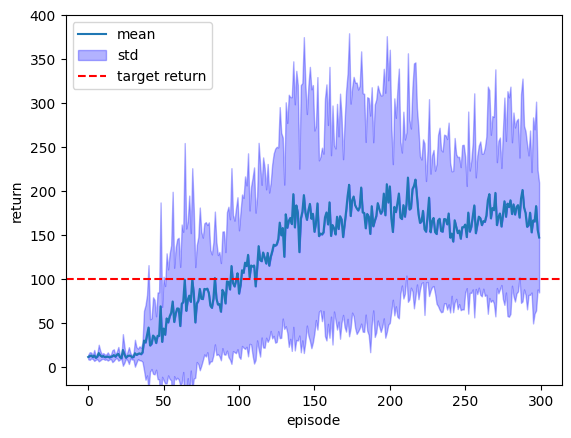

In [61]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it

plt.plot(torch.arange(300), means, label="mean")
plt.ylabel("return")
plt.xlabel("episode")
plt.ylim([-20,400])
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b',label="std")
plt.axhline(y = 100, color = 'r', linestyle = '--',label= "target return")
plt.legend(loc="upper left")
plt.show()

In [94]:
# Pickle results to plot DDQN and DQN in the same graph
saved_results = [results, means, stds]
if is_DDQN:
    with open("saved_DDQNcurve.pickle", 'wb') as target:
        pickle.dump(saved_results, target)
else:
    with open('saved_curve.pickle', 'wb') as target:
        pickle.dump(saved_results, target)

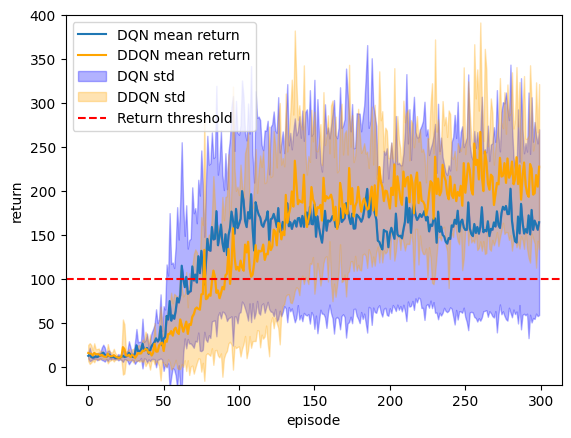

In [95]:
# Load results and plot curve
with open('saved_curve.pickle', 'rb') as target:
    saved_results = pickle.load(target)
with open('saved_DDQNcurve.pickle', 'rb') as target:
    saved_DDQN_results = pickle.load(target)
    
results = saved_results[0]
means = saved_results[1]
stds = saved_results[2]

DDQN_results = saved_DDQN_results[0]
DDQN_means = saved_DDQN_results[1]
DDQN_stds = saved_DDQN_results[2]

plt.plot(torch.arange(300), means, label="DQN mean return")
plt.plot(torch.arange(300), DDQN_means, color="orange", label="DDQN mean return")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b',label="DQN std")
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.ylim([-20,400])
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(300), DDQN_means, DDQN_means+DDQN_stds, alpha=0.3, color='orange',label="DDQN std")
plt.fill_between(np.arange(300), DDQN_means, DDQN_means-DDQN_stds, alpha=0.3, color='orange')
plt.axhline(y = 100, color = 'r', linestyle = '--', label="Return threshold")
plt.legend(loc = "upper left")
plt.show()

In [96]:
# Pickle results
saved_DQN_model = policy_net
with open('saved_DQN_model.pickle', 'wb') as target:
    pickle.dump(saved_DQN_model, target)

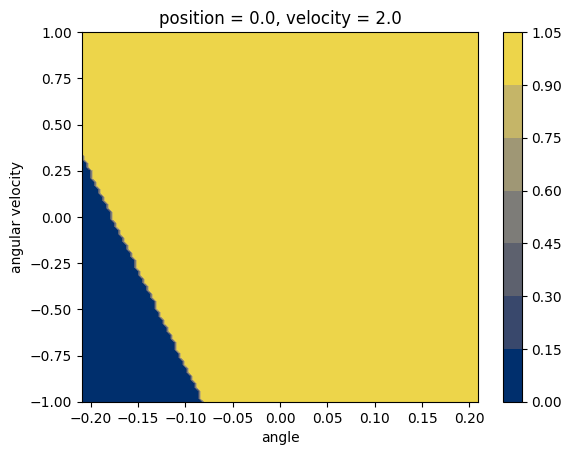

In [98]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can modify these plots

# Make sure to include appropriate labels and/or legends when presenting your plot

with open('saved_DQN_model.pickle', 'rb') as target:
    saved_model = pickle.load(target)

policy_net = saved_model   # randomly initialised, replace with your trained DQN
q = False    # whether q values or greedy policy is visualised

angle_range = .2095 # you may modify this range
omega_range = 1     # you may modify this range
position = 0.
velocity = 2.0 

angle_samples = 100
omega_samples = 100
angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)

greedy_q_array = torch.zeros((angle_samples, omega_samples))
policy_array = torch.zeros((angle_samples, omega_samples))
for i, angle in enumerate(angles):
    for j, omega in enumerate(omegas):
        state = torch.tensor([position, velocity, angle, omega]) # change this to plot 4 graphs
        with torch.no_grad():
            q_vals = policy_net(state)
            greedy_action = q_vals.argmax()
            greedy_q_array[i, j] = q_vals[greedy_action]
            policy_array[i, j] = greedy_action
if q:
    plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
else:
    plt.contourf(angles, omegas, policy_array.T, cmap='cividis')

plt.xlabel("angle")
plt.ylabel("angular velocity")
plt.title(label=f'position = {position}, velocity = {velocity}')
plt.colorbar()
plt.show()